In [1]:
from SimPEG import *
from SimPEG import EM
from scipy.constants import mu_0
import numpy as np
import scipy.sparse as sp
from simpegEMIP.TDEM import geteref, Problem3DIP_Linear, SurveyLinear
from simpegEMIP.TDEM import Survey, Rx
from simpegEMIP.TDEM import Problem3DEM_e, Problem3D_e
import matplotlib.pyplot as plt
from pymatsolver import PardisoSolver
eps = np.finfo(float).eps

Simulatin and synthetic study on deep sea hydrothermal deposits explortaion using WISTEM (K. Nakayama and A. Saito, 2016) (K.Nakayama M. Motoori and A. Saito,2019).
On-Time: 200msec
ramp time: 200usec
Transmitter Loop: 3.5m Square Loop
Receiver Loop: Coincident-type
Number of Turn: 5
3.5m rectangular loop has equivalent area for 2.0m circular. 

In [2]:
tx_radius = (3.5)/(np.sqrt(np.pi))
tx_circumference = 2*np.pi*tx_radius
tx_area = np.pi*tx_radius**2
n_turns = 5
print(f"radius of transmitter: {tx_radius}")

radius of transmitter: 1.9746635424171473


In [3]:
#cs, ncx, ncz, npad = 10., 25, 20, 18
csx, csz = tx_radius/4.,tx_radius/4.
ncx, ncz  = 100, 100 
pf, npadx, npadz = 1.3 , 26, 26
hx = [(csx, ncx), (csx, npadx, pf)]
hz = [(csz, npadz, -pf), (csz, 2*ncz), (csz, npadz, pf)]
mesh = Mesh.CylMesh([hx,1,hz], '00C')    
print(f'number of mesh {mesh.nC}')
print(csx)

number of mesh 31752
0.4936658856042868


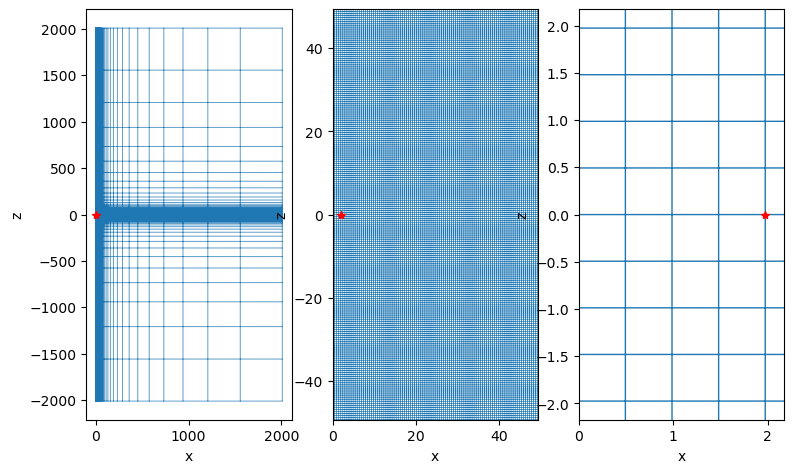

In [4]:
fig, ax = plt.subplots(1,3, figsize=(9,7))
ax[0] = mesh.plotGrid(ax=ax[0], show_it=False, linewidth=0.5)  
ax[1] =  mesh.plotGrid(ax=ax[1], show_it=False, linewidth=0.5)
#ax[1] =  mesh.plot_grid(show_it=True)
ax[1].set_xlim(0., ncx*csx)
ax[1].set_ylim(-ncz*csz , ncz*csz )
ax[2] =  mesh.plotGrid(ax=ax[2], show_it=False, linewidth=1.0)
ax[2].set_xlim(0.,tx_radius*1.1)
ax[2].set_ylim(-tx_radius*1.1,tx_radius*1.1)

for a in ax:
    a.set_aspect('equal')
    a.plot(tx_radius,0,'r*')
    a.grid(False)

In [5]:
sigma_sea = 3.0
sigma_seabed = 1.0
sigma_target = 1/0.15
eta_target = 0.3
tau_target = 1.0e-3
c_target = 0.8
thick_target = 30.
tx_height = csx
print(tx_height)

0.4936658856042868


In [6]:
sigmaInf = np.ones(mesh.nC)*sigma_sea
inds_layer = np.logical_and(mesh.gridCC[:,2]<-tx_height, mesh.gridCC[:,2]>-tx_height-thick_target)
sigmaInf[inds_layer] = sigma_target/(1-eta_target)
print(f"sigma_inf: {sigma_target/(1-eta_target):3e}")
inds_bed = mesh.gridCC[:,2] <= - tx_height-thick_target
sigmaInf[inds_bed] = sigma_seabed

sigma_inf: 9.523810e+00


In [7]:
eta = np.zeros(mesh.nC)
eta[inds_layer] = eta_target
tau=np.ones(mesh.nC)
tau[inds_layer] = tau_target
c=np.ones(mesh.nC)
c[inds_layer] = c_target

In [8]:
time_steps = [(2e-6,  150),  (5e-6,  150),  (2e-5,  150), (5e-5,  10)]
tstrt, tend = 1e-4, 4.0e-3
steps = np.array([])
for i in range(len(time_steps)):
    dt, n = time_steps[i]
    step_array = dt * np.ones(n)
    steps = np.concatenate((steps, step_array))
time_clc = np.cumsum(steps)
# since using step off waveform
rmp_time = time_clc[0]
time_rec = time_clc[1:] -rmp_time
#time_rec = np.logspace(np.log10(1e-5), np.log10(1e-2), 31)
print(time_rec.shape)

(459,)


In [9]:
#Get EM data
srcloc = np.array([[0., 0., 0.]])

waveform = EM.TDEM.Src.StepOffWaveform()
#waveform = EM.TDEM.Src.RampOffWaveform(offTime = rmp_time)
#waveform = EM.TDEM.Src.VTEMWaveform(offTime=t0, peakTime=tpeak, a=3.)
rxloc = np.array([[0, 0., 0.]])
rx_b = Rx.Point_dbdt(locs=rxloc, times= time_rec, orientation='z')

rxloc = np.array([[tx_radius, 0., 0.]])
rx_e = Rx.Point_e(locs=rxloc, times= time_rec+rmp_time, orientation='y')


src = EM.TDEM.Src.CircularLoop([rx_b,rx_e],radius=tx_radius, waveform=waveform, loc=srcloc)
survey = Survey([src])
#prb = Problem3DEM_e(mesh, sigma=sigmaInf)
prb_emip = Problem3D_e(mesh, sigmaInf=sigmaInf, eta=eta, tau=tau, c=c)
prb_emip.timeSteps =time_steps
prb_emip.Solver = PardisoSolver
prb_emip.pair(survey)



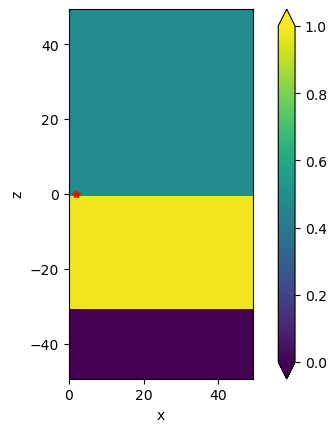

In [10]:
cb= mesh.plotImage(np.log10(sigmaInf))
plt.colorbar(cb[0], ax=plt.gca(), extend='both')
plt.plot(src.radius,0,'r*')
cb[0].set_clim(1, 0) 
cb[0].set_label('$ \log_{10}SurveyLinear $')
plt.xlim(0., ncx*csx)
plt.ylim(-ncz*csz, ncz*csz )
plt.gca().set_aspect('equal')

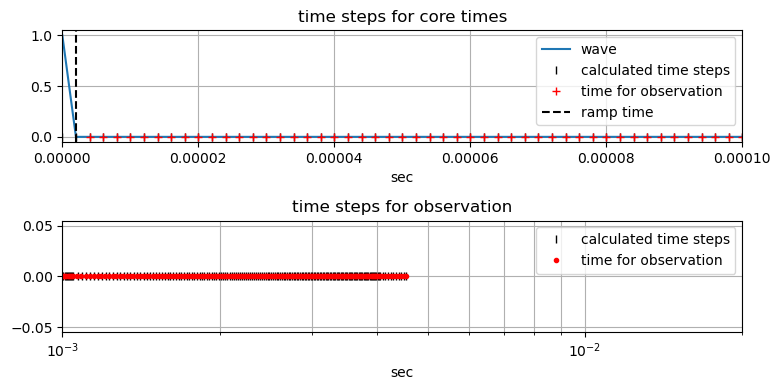

In [11]:
fig, ax = plt.subplots(2,1,figsize=(8,4))
ax[0].plot(prb_emip.times, [waveform.eval(t) for t in prb_emip.times],label='wave')
ax[0].plot(prb_emip.times, np.zeros_like(prb_emip.times), "|k",label='calculated time steps')
ax[0].plot(time_rec+rmp_time, np.zeros_like(time_rec), "+r",lw=3,label='time for observation')
ax[0].axvline(rmp_time, color='k', linestyle='--',label='ramp time')
ax[0].set_xlim(0,1e-4)#time_steps[0][0]*time_steps[0][1])
ax[0].set_title('time steps for core times')

ax[1].semilogx(prb_emip.times, np.zeros_like(prb_emip.times), "|k",label='calculated time steps')
ax[1].semilogx(time_rec, np.zeros_like(time_rec), "r.",lw=3,label='time for observation')
ax[1].set_title('time steps for observation')
ax[1].set_xlim(1e-3,2e-2)#time_steps[0][0]*time_steps[0][1])

for a in ax:
    a.grid(which='both')
    a.set_xlabel('sec')
    a.legend()
plt.tight_layout()
plt.show()

In [12]:
fields_emip = prb_emip.fields(sigmaInf)

C:\Users\81805\anaconda3\envs\simpegEMIP\lib\site-packages\SimPEG\Props.py:400: UserWarning: Cannot add model as there are no active mappings, choose from: ['cMap', 'etaMap', 'rhoMap', 'sigmaInfMap', 'sigmaMap', 'tauMap']
  "', '".join(self._all_map_names)


In [13]:
# Get data from fields
data_emip = survey.dpred(sigmaInf, f=fields_emip)

In [14]:
#dpred_emip = -data_emip * n_turns *tx_area
# for E-edge receiver
dpred_emip_b = -data_emip[:len(time_rec)] * n_turns *tx_area
dpred_emip_e =  data_emip[len(time_rec):] * n_turns *tx_circumference

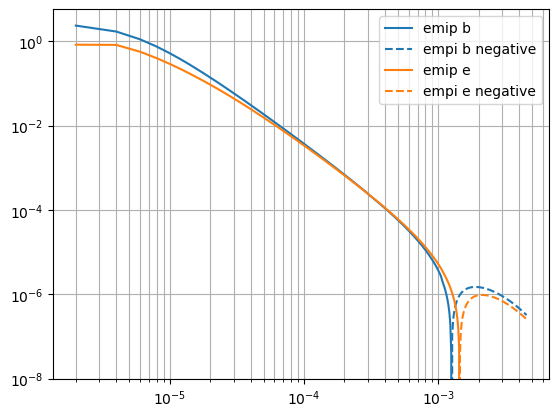

In [15]:
plt.loglog(time_rec, dpred_emip_b, 'C0', label="emip b" )
plt.loglog(time_rec,-dpred_emip_b, 'C0',linestyle='--', label="empi b negative")
plt.loglog(time_rec, dpred_emip_e, 'C1', label="emip e" )
plt.loglog(time_rec,-dpred_emip_e, 'C1',linestyle='--', label="empi e negative")
plt.legend()
#plt.ylim([1e-7,1e-2])
plt.ylim(bottom=1e-8)

plt.grid(True, which='both')

In [16]:
# Adjust ramp time and export data in numpy format
np_save = np.zeros((3,len(time_rec)))
np_save[0,:] = time_rec
np_save[1,:] = dpred_emip_b
np_save[2,:] = dpred_emip_e
np.save("13_Validation_simpegEMIP.npy", np_save)

In [17]:
np.save("13_fields_emip.npy", fields_emip[:,0,2:])
np.save("13_time_clc.npy", time_clc[1:]-rmp_time)